# Original implementation

We compare the framework with a preexisting application of GPs to the glacier elevation interpolation problem. In this setup, the study area in split up in to 30 by 30km squares. The x-y coordinates, elevation and the logarithm of the velocity are used as predictors. A zero mean function and squared exponential kernel with ARD is used, except along the x-y coordinates which are constrained to have the same lengthscale and variance.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score
from utils import metrics 
import gpytorch
import torch
import time

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### Load and process data

In [2]:
# Load the data
df = pd.read_csv('data/glacier_dataset_targets.csv', usecols=[ 'elev', 'slope', 'vel', 'dhdt_filt', 'x', 'y', 'date_min', 'date_max'])

In [3]:
# Transform the data
df['vel_log'] = np.log(df['vel'])

In [4]:
# Split data into training, validation and test sets
## Group along satellite tracks 
df['group'] = df.groupby(['date_min', 'date_max']).cumcount() 

In [5]:
## Split into training and evaluation set (70%/30%)
gss1 = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
indices1 = gss1.split(X=df[['elev', 'vel_log', 'x', 'y', ]].values, y=df['dhdt_filt'].values, groups=df.group.values)
for i in indices1:
    (train_index, eval_index) = i
    print(f"  Train: index={train_index}, group={df.group.values[train_index]}")
    print(f"  Test:  index={eval_index}, group={df.group.values[eval_index]}")
train_df = df.iloc[train_index]

  Train: index=[     0      1      2 ... 497136 497138 497139], group=[    0     1     2 ...   875 18721    27]
  Test:  index=[     4      6      7 ... 497128 497134 497137], group=[    4     6     7 ...  1741 18719 18720]


In [6]:
## Split into validation and test set (33%/67%)
eval_df = df.iloc[eval_index]
gss2 = GroupShuffleSplit(n_splits=1, train_size=.3333, random_state=42)
indices2 = gss2.split(X=eval_df[['elev', 'vel_log', 'x', 'y', ]].values,
                      y=eval_df['dhdt_filt'].values, groups=eval_df.group.values)
for i in indices2:
    (val_index, test_index) = i
    print(f"  Train: index={val_index}, group={eval_df.group.values[val_index]}")
    print(f"  Test:  index={test_index}, group={eval_df.group.values[test_index]}")
val_df = eval_df.iloc[val_index]
test_df = eval_df.iloc[test_index]

  Train: index=[     1      5      8 ... 150135 150136 150142], group=[    6     6     6 ... 20379 10226 18719]
  Test:  index=[     0      2      3 ... 150140 150141 150143], group=[    4     7     4 ... 20385  1741 18720]


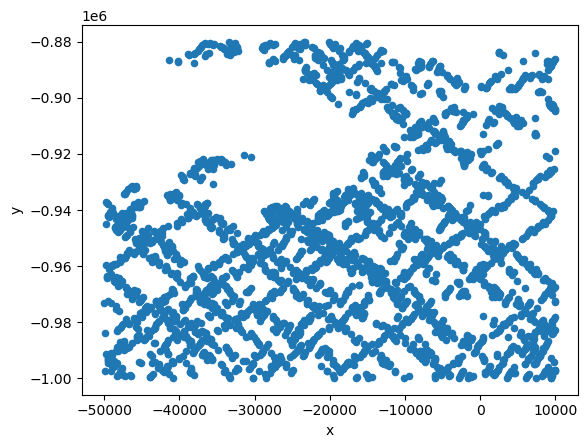

In [7]:
# Save a subset for plotting
plot_df = train_df[(train_df['x'] > -50000) & (train_df['x'] < 10000) & (train_df['y'] > -1e6) & (train_df['y'] < -8.8e5)]
plot_df.plot.scatter(x='x', y='y')
plot_df.to_csv('data/plot_train_data.csv')

In [8]:
# Divide the data into the 30km chunks

squares = []

min_x = df.x.min()  # study area extent
min_y = df.y.min()
max_x = df.x.max()
max_y = df.y.max()

res = 30e3  # in metres

for n in tqdm(np.arange(min_x, max_x, res)):

    for m in np.arange(min_y, max_y, res):

        df_train_chunk = train_df[(train_df.x>=n) & (train_df.x<n+res) & ((train_df.y>=m) & (train_df.y<m+res))]
        df_val_chunk = val_df[(val_df.x>=n) & (val_df.x<n+res) & ((val_df.y>=m) & (val_df.y<m+res))]
        df_test_chunk = test_df[(test_df.x>=n) & (test_df.x<n+res) & ((test_df.y>=m) & (test_df.y<m+res))]

        if len(df_train_chunk.values)>0:
            if len(df_test_chunk.values) >= 2: # only test squares with two or more test points
                ytrain = df_train_chunk['dhdt_filt'].values
                # 'elev', 'slope', 'vel_log',
                xtrain = df_train_chunk[['x', 'y', 'vel_log', 'elev', ]].values
                yval = df_val_chunk['dhdt_filt'].values
                xval = df_val_chunk[[ 'x', 'y', 'vel_log', 'elev',]].values
                ytest = df_test_chunk['dhdt_filt'].values
                xtest = df_test_chunk[[ 'x', 'y', 'vel_log', 'elev',]].values
                squares.append([xtrain, ytrain, xval, yval, xtest, ytest])

100%|██████████| 50/50 [00:14<00:00,  3.53it/s]


### Train and evaluate model

In [9]:
# GPytorch GP model class

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        k1 = gpytorch.kernels.RBFKernel(
            2, active_dims=[0, 1]).initialize(lengthscale=4e3) # Alex's initialisations
        k2 = gpytorch.kernels.RBFKernel(ard_num_dims=2, active_dims=[
                                        2, 3]).initialize(lengthscale=[1, 200])
        self.covar_module = gpytorch.kernels.ScaleKernel(k1 * k2)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [10]:
# Fit GPs to the data

R2 = []
RMSE_mean = []
RMSE_95 = []
RMSE_5 = []
MLL = []

training_iter = 150
start = time.time()

for square in tqdm(squares):

    xtrain, ytrain, xval, yval, xtest, ytest = square
    train_x, train_y = torch.Tensor(xtrain), torch.Tensor(ytrain)
    test_x, test_y = torch.Tensor(xtest), torch.Tensor(ytest)

    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
        #noise=torch.ones(len(train_x))*0.1)
    model = ExactGPModel(train_x, train_y, likelihood)

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    # Includes GaussianLikelihood parameters
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    try:

        for i in range(training_iter):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = model(train_x)
            # Calc loss and backprop gradients
            loss = -mll(output, train_y)
            loss.backward()
            '''
            print('Iter %d/%d - Loss: %.3f  noise: %.3f' % (
                i + 1, training_iter, loss.item(),
                #model.covar_module.base_kernel.lengthscale.item(),
                model.likelihood.noise.item()))
            '''
            optimizer.step()

        model.eval()
        likelihood.eval()

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            #test_noises = torch.ones(len(test_x)) * 0.1
            preds = likelihood(model(test_x)) #noise=test_noises)
            y_pred = preds.mean.numpy()
            y_var = preds.variance.numpy()

        R2.append(r2_score(test_y.numpy(), y_pred))
        RMSE_mean.append(mean_squared_error(test_y.numpy(), y_pred, squared=False))
        MLL.append(metrics.mll(test_y.numpy(), y_pred, y_var))
        
        rmse95 = metrics.RMSE95(test_y.numpy(), y_pred)
        RMSE_95.append(rmse95)
        rmse5 = metrics.RMSE5(test_y.numpy(), y_pred)
        RMSE_5.append(rmse5)

    except:
        print(square)
        pass

end = time.time()
print(end - start)

100%|██████████| 2229/2229 [00:09<00:00, 231.10it/s]

9.647045850753784


In [11]:
print('Mean RMSE = ', np.mean(RMSE_mean), '±', np.std(RMSE_mean))
print('Mean R2 = ', np.mean(R2), '±', np.std(R2))
print('95th percent. RMSE = ', np.mean(RMSE_95), '±', np.std(RMSE_95))
print('5th percent. RMSE = ', np.mean(RMSE_5), '±', np.std(RMSE_5))
print('MSLL= ', np.mean(MLL), '±', np.std(MLL))

Mean RMSE =  0.085629046 ± 0.1729553
Mean R2 =  -2.231734618093606 ± 58.01906435606697
95th percent. RMSE =  0.06238353 ± 0.08911322
5th percent. RMSE =  0.15416127 ± 0.3476378
MSLL=  0.8360258 ± 0.14254217


0.4259006902125272

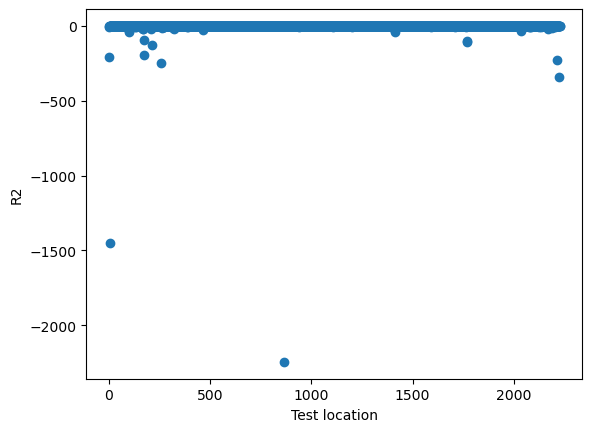

In [12]:
# Do we have many outliers?
plt.scatter(np.arange(len(R2)), R2)
plt.ylabel('R2')
plt.xlabel('Test location')
np.median(R2)

### Plots on data subset

Can be run indepedently of the rest of the notebook.

In [13]:
# Model output subset of the data

## Train GPs on subset only

### Load the data
df_test = pd.read_csv('data/plot_test_data.csv',
                      usecols=['elev', 'slope', 'x', 'y', 'vel'])
df_train = pd.read_csv('data/plot_train_data.csv', usecols=['elev', 'x', 'y', 'vel', 'dhdt_filt'])

### Transform the data
df_train['vel_log'] = np.log(df_train['vel'])
df_test['vel_log'] = np.log(df_test['vel'])

### Divide the data into the 30km chunks

squares = []

min_x = df_test.x.min()  # study area extent
min_y = df_test.y.min()
max_x = df_test.x.max()
max_y = df_test.y.max()

res = 30e3

for n in tqdm(np.arange(min_x, max_x, res)):

    for m in np.arange(min_y, max_y, res):

        df_chunk_train = df_train[(df_train.x >= n) & (
            df_train.x < n+res) & ((df_train.y >= m) & (df_train.y < m+res))]

        df_chunk_test = df_test[(df_test.x >= n) & (
            df_test.x < n+res) & ((df_test.y >= m) & (df_test.y < m+res))]

        if len(df_chunk_test.values) > 0:
            ytrain = df_chunk_train['dhdt_filt'].values
            xtrain = df_chunk_train[['x', 'y', 'vel_log', 'elev',]].values 
            xtest =  df_chunk_test[['x', 'y', 'vel_log', 'elev',]].values
            squares.append([xtrain, ytrain, xtest])

100%|██████████| 2/2 [00:00<00:00, 178.16it/s]


In [14]:
# GPytorch GP model class (same as above)

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        k1 = gpytorch.kernels.RBFKernel(
            2, active_dims=[0, 1]).initialize(lengthscale=4e3)
        k2 = gpytorch.kernels.RBFKernel(ard_num_dims=2, active_dims=[
                                        2, 3]).initialize(lengthscale=[1, 200])
        self.covar_module=gpytorch.kernels.ScaleKernel(k1 * k2)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [15]:
# Fit the data

training_iter = 150

pred_list = []
xtest_list = []

for square in tqdm(squares[:]):

    xtrain, ytrain, xtest = square
    train_x1, train_y1 = torch.Tensor(xtrain), torch.Tensor(ytrain)
    test_x1 = torch.Tensor(xtest)

    # initialize likelihood and model
    likelihood1 = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=torch.ones(len(train_x1))*0.1)
    model1 = ExactGPModel(train_x1, train_y1, likelihood1)

    # Find optimal model hyperparameters
    model1.train()
    likelihood1.train()

    # Use the adam optimizer
    # Includes GaussianLikelihood parameters
  
    optimizer = torch.optim.Adam(model1.parameters(), lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood1, model1)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model1(train_x1)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y1)
        loss.backward()
        '''
        print('Iter %d/%d - Loss: %.3f ' % (
            i + 1, training_iter, loss.item(),))
            #model.covar_module.base_kernel.lengthscale.item(),
        #model.likelihood.noise.item()))  noise: %.3f'
        '''
        optimizer.step()

    model1.eval()
    likelihood1.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds = likelihood1(model1(test_x1))
        y_pred = preds.mean.numpy()
        y_var = preds.variance.numpy()
        
    pred_list.extend(y_pred)
    xtest_list.extend(xtest)
        

  0%|          | 0/8 [00:00<?, ?it/s]/Users/kenzatazi/miniconda3/envs/gp-frame/lib/python3.10/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:270: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(
100%|██████████| 8/8 [00:21<00:00,  2.72s/it]


In [16]:
# Convert to numpy arrays
y_pred = np.array(pred_list)
xtest = np.array(xtest_list)

(22978, 4)

In [17]:
# Save the data
# df_og = pd.DataFrame(data={'x': xtest[:, 0], 'y':xtest[:, 1], 'ypred':y_pred})
# df_og.to_csv('data/og_output.csv')


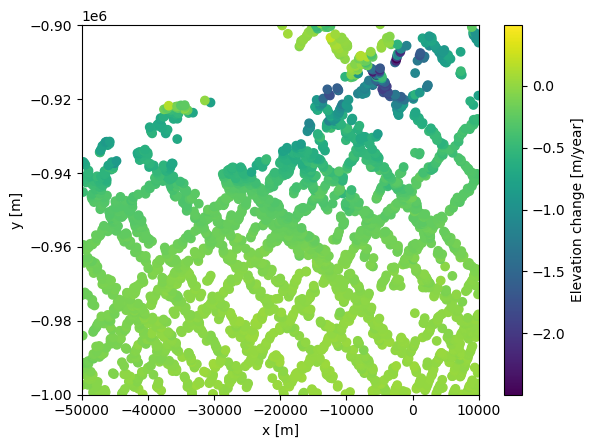

In [20]:
# Plot the training data
plt.scatter(df_train['x'], df_train['y'], c=df_train['dhdt_filt'])
plt.colorbar(label='Elevation change [m/year]')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.xlim(-50000,10000)
plt.ylim(-1e6, -9e5)
plt.show()

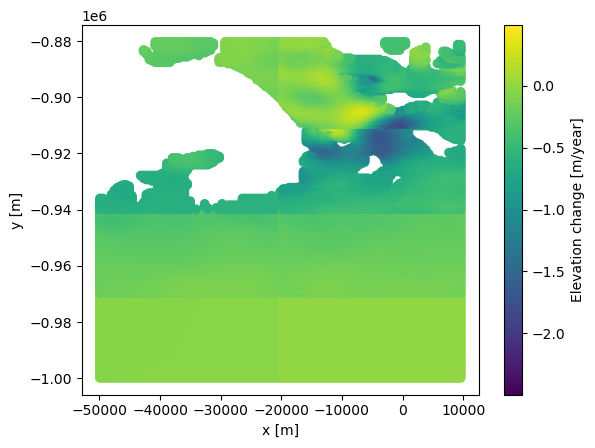

In [21]:
# Plot the results
plt.scatter(xtest[:, 0], xtest[:, 1], c=y_pred[:],
            vmin=df_train['dhdt_filt'].min(), vmax=df_train['dhdt_filt'].max())
plt.colorbar(label='Elevation change [m/year]')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()